In [1]:

%load_ext tensorboard

In [2]:
from PIL import Image
import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import requests
import scipy as sp
import tensorflow as tf
import tensorflow.keras as keras
import zipfile
from tensorflow.keras import models
from tensorflow.keras import layers
import datetime

In [3]:
data_dir = '../projects/apple_disease_classification/data/Train'

import tensorflow as tf

img_height = 160
img_width = 160
batch_size = 32

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

train_label = train_ds.class_names

Found 381 files belonging to 2 classes.


In [5]:

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_label = val_ds.class_names


Found 381 files belonging to 2 classes.
Using 38 files for validation.


In [6]:
test_data_dir = '../projects/apple_disease_classification/data/Test'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(img_height, img_width),
    shuffle=False,
    batch_size=batch_size)
    


test_label = test_ds.class_names
print(test_label)

Found 120 files belonging to 2 classes.
['Normal_Apple', 'Reject_Apple']


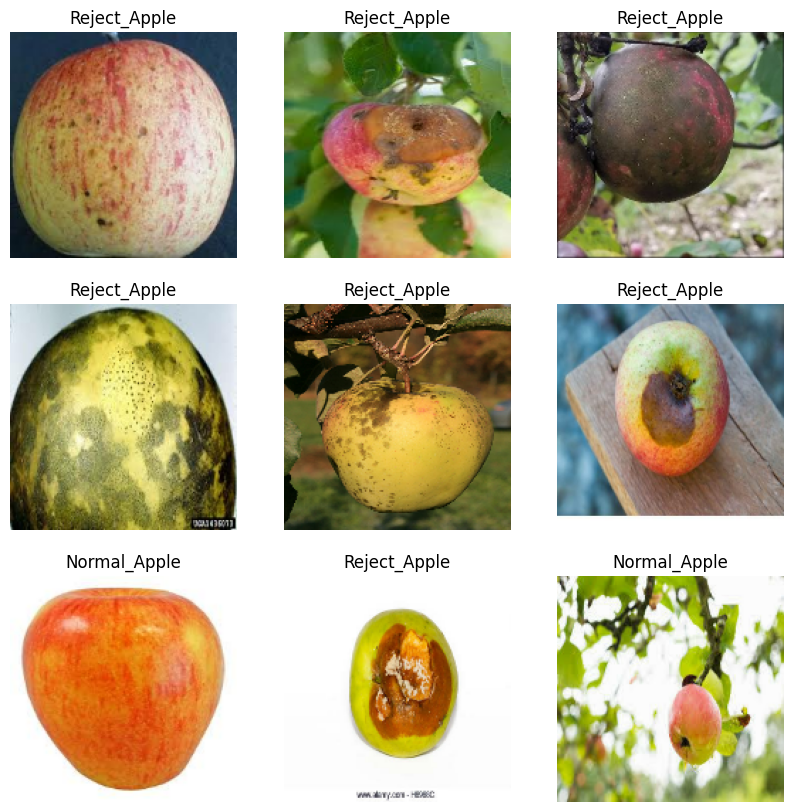

In [7]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [8]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)


In [10]:
print(train_label)
print(val_label)

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

['Normal_Apple', 'Reject_Apple']
['Normal_Apple', 'Reject_Apple']
(32, 160, 160, 3)
(32,)


In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


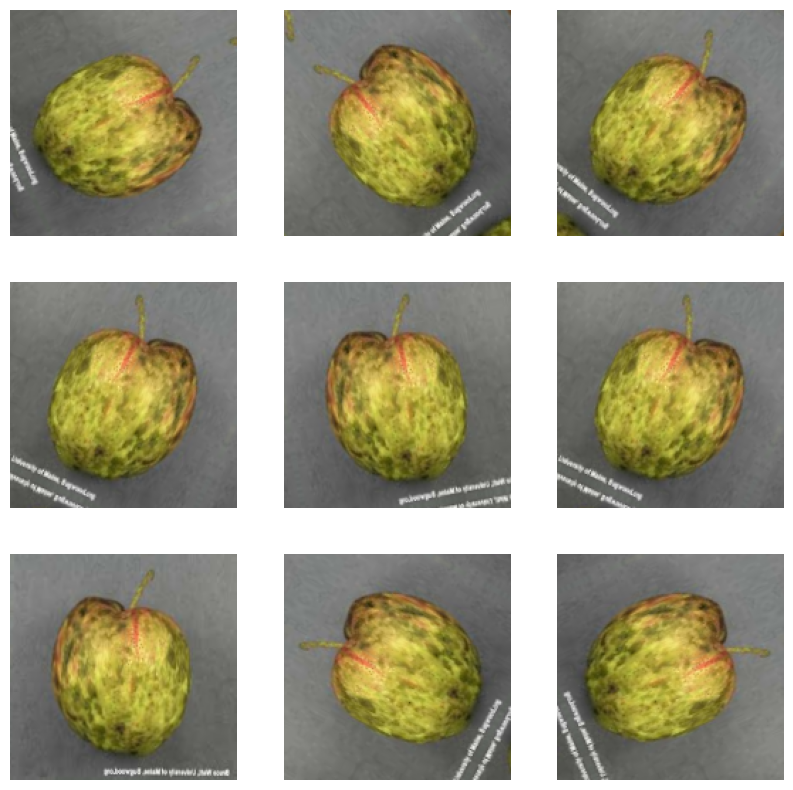

In [12]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


In [15]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (img_height, img_width)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')



In [16]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)



(32, 1280)


In [18]:
base_model.trainable = False

In [19]:
prediction_layer = tf.keras.layers.Dense(2)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)



(32, 2)


In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [22]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [23]:
log_dir = "logs/log" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + 'MobileNetV2'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [24]:
len(model.trainable_variables)


2

In [25]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(val_ds)


2/2 [==============================] - 2s 87ms/step - loss: 5.5192 - accuracy: 0.4474


In [26]:

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)


print(history.history.keys())
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


Epoch 1/15
12/12 [==============================] - 9s 489ms/step - loss: 4.2035 - accuracy: 0.5249 - val_loss: 3.1715 - val_accuracy: 0.5263
Epoch 2/15
12/12 [==============================] - 6s 485ms/step - loss: 3.9727 - accuracy: 0.5748 - val_loss: 2.6837 - val_accuracy: 0.6053
Epoch 3/15
12/12 [==============================] - 6s 487ms/step - loss: 3.1259 - accuracy: 0.6089 - val_loss: 2.2206 - val_accuracy: 0.6842
Epoch 4/15
12/12 [==============================] - 6s 489ms/step - loss: 2.9057 - accuracy: 0.6693 - val_loss: 1.7856 - val_accuracy: 0.6842
Epoch 5/15
12/12 [==============================] - 7s 501ms/step - loss: 2.5033 - accuracy: 0.6955 - val_loss: 1.0881 - val_accuracy: 0.7105
Epoch 6/15
12/12 [==============================] - 7s 514ms/step - loss: 2.4146 - accuracy: 0.7034 - val_loss: 1.0590 - val_accuracy: 0.7632
Epoch 7/15
12/12 [==============================] - 6s 497ms/step - loss: 2.0908 - accuracy: 0.7244 - val_loss: 0.6918 - val_accuracy: 0.7632
Epoch 

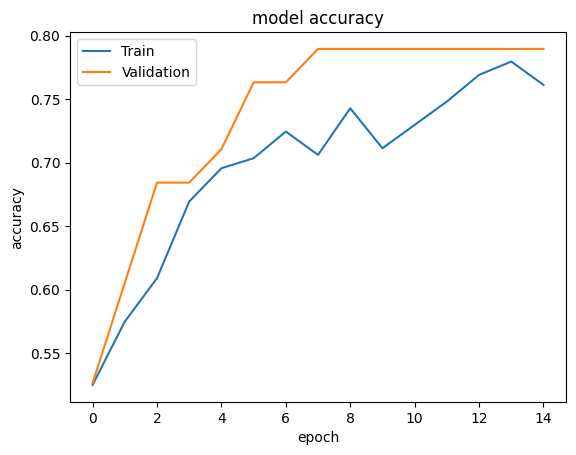

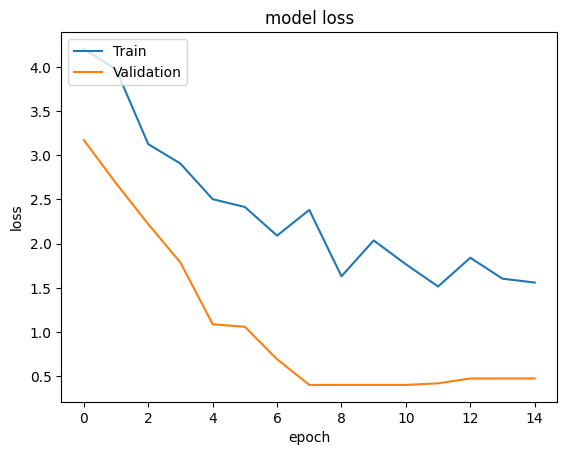

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.ylim(0,10)
plt.show()

In [28]:
#%tensorboard --logdir logs/log

In [29]:
'!kill 1464'

'!kill 1464'

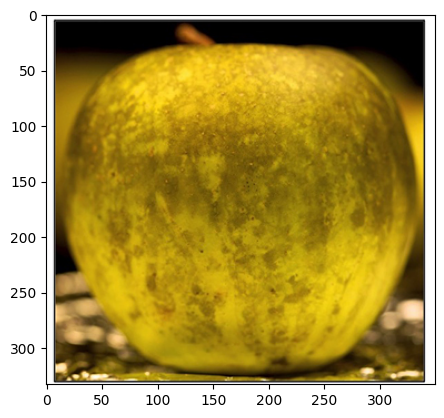

In [30]:
img = Image.open('C:/Users/Anton/MakeAIWork2/projects/apple_disease_classification/data/Use/30.jpg')


#laat plaatje zien
plt.imshow(img)

#iets met predict doen

In [31]:
img_array = tf.keras.utils.img_to_array(np.resize(img,(160,160,3)))
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to Reject_Apple with a 82.50 percent confidence.


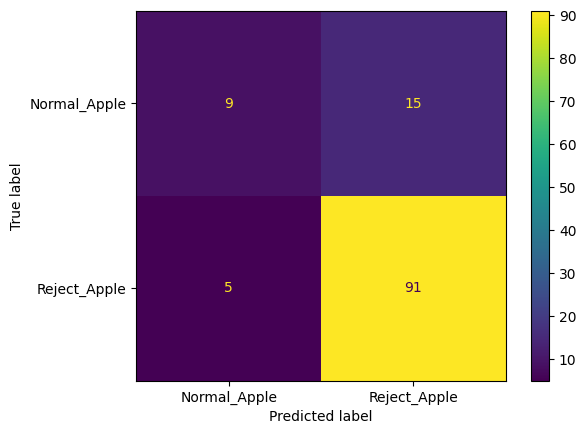

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
batchPredictions = model.predict(test_ds)
predicted_categories = tf.argmax(batchPredictions, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)
# confusion_matrix(predicted_categories, true_categories)


confusion_matrix = confusion_matrix(true_categories, predicted_categories)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = ['Normal_Apple', 'Reject_Apple'])

cm_display.plot()
plt.show() 

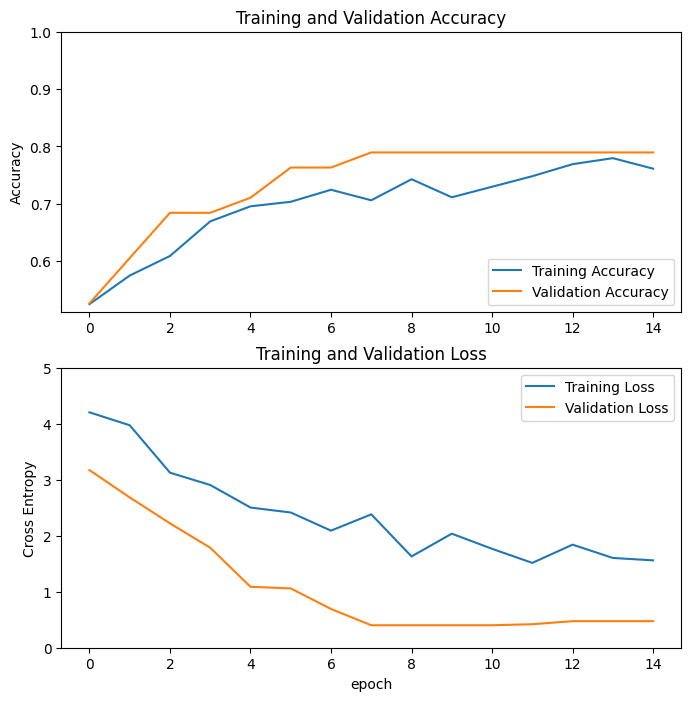

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
